In [1]:
import tensorflow as tf
import collections
import tensorflow_federated as tff

import numpy as np

2026-02-17 09:16:07.817942: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-17 09:16:07.840104: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-17 09:16:07.840124: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-17 09:16:07.840139: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-17 09:16:07.844524: I tensorflow/core/platform/cpu_feature_g

In [2]:
import tensorflow.keras.backend as K
import gc

K.clear_session()  # Clear TF session to free GPU memory
gc.collect()

199

In [3]:
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.14.1


2026-02-17 09:16:37.839580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-17 09:16:37.844486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-17 09:16:37.846118: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
)

kidney_dataset = datagen.flow_from_directory(
    '/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer',
    target_size=(224,224),
    class_mode='categorical',
    shuffle=True,
    seed=42,
    batch_size=32,
)

Found 3498 images belonging to 2 classes.


Batch shape: (32, 224, 224, 3)
Single image shape: (224, 224, 3)
Min pixel value: 0.0
Max pixel value: 1.0
Label [1. 0.]


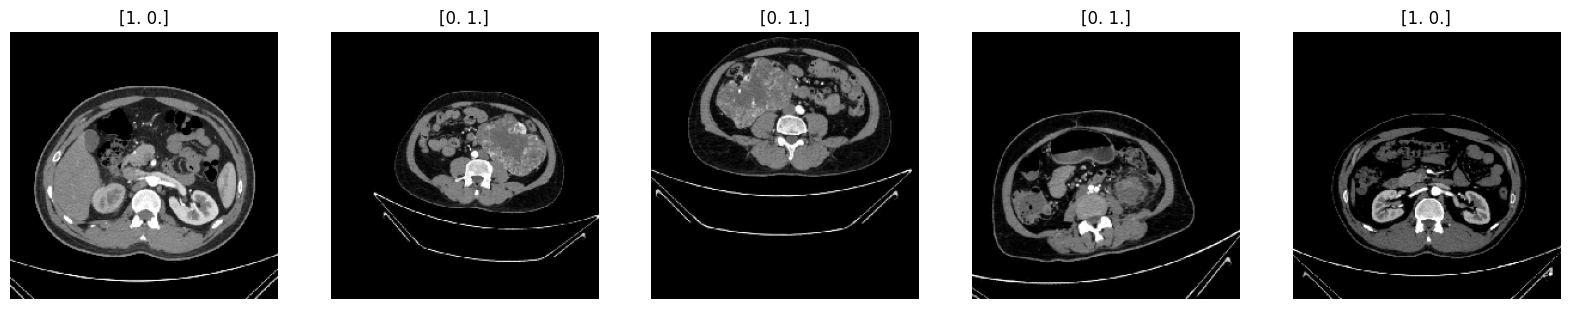

In [5]:
import matplotlib.pyplot as plt
images, labels = next(kidney_dataset)
for i in range(1):
    print("Batch shape:", images.shape)
    print("Single image shape:", images[0].shape)
    print("Min pixel value:", images.min())
    print("Max pixel value:", images.max())
    print("Label", labels[0])

fig, ax = plt.subplots(1, 5, figsize=(20,5))
for i in range(5):
    ax[i].imshow(images[i])
    ax[i].set_title(labels[i])
    ax[i].axis('off')

plt.show()


In [6]:
type(kidney_dataset)

keras.src.preprocessing.image.DirectoryIterator

In [7]:
import os

data_dir = '/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer'
class_names = os.listdir('/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer')
class_labels = {name: idx for idx, name in enumerate(class_names)}

print(class_labels)

image_paths = []
labels = []
for class_name in class_names:
    path1 = os.path.join(data_dir, class_name)
    print(path1)
    paths = os.listdir(path1)
    for path in paths:
        image_paths.append(os.path.join(path1, path))
        labels.append(class_labels[class_name])

print(image_paths[1])

{'kidney_normal': 0, 'kidney_tumor': 1}
/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer/kidney_normal
/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer/kidney_tumor
/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer/kidney_normal/kidney_normal_0403.jpg


In [8]:
NUM_MALICIOUS = 3
FLIP_PROB = 0.4

In [9]:
import os
import random

class_names = os.listdir('/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer')
class_labels = {name: idx for idx, name in enumerate(class_names)}

fake_clients = []

def load_image(path, img_size=(224, 224)):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0
    return img

def create_client_dataset(image_paths, label, img_size=(224, 224), flip=False, num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42):
    images = []
    labels = []
    target_size=(64, 64)
    for i, path in enumerate(image_paths):
        img = load_image(path, img_size)
        img = tf.image.resize(img, target_size)
        images.append(img)
        labels.append(label[i])

    labels = np.array(labels, dtype=np.int32)
    if flip:
        rng = np.random.RandomState(seed)
        num_classes = len(np.unique(labels))
        n = len(labels)

        # randomly choose which samples to flip
        mask = rng.rand(n) < float(flip_prob)

        if mask.sum() > 0:
            rand_targets = rng.randint(0, num_classes, size=n)
            # ensure flipped label != original label
            rand_targets[rand_targets == labels] = (rand_targets[rand_targets == labels] + 1) % num_classes
            labels[mask] = rand_targets[mask]

    print(f"{len(images)}  {len(labels)}   malicious_client={flip}")
    ds = tf.data.Dataset.from_tensor_slices((images, labels.tolist()))
    ds = ds.shuffle(buffer_size=len(images)).batch(8)
    return ds


def prepare_client_dataset(data_dir, num_client, num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42):
    image_paths = []
    labels = []

    class_names = os.listdir('/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer')
    class_labels = {name: idx for idx, name in enumerate(class_names)}
    print(class_labels)

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        paths = os.listdir(class_path)
        for path in paths:
            image_paths.append(os.path.join(class_path, path))
            labels.append(class_labels[class_name])

    #image_paths = image_paths[:4000]
    combined = list(zip(image_paths, labels))
    rng = random.Random(seed)
    rng.shuffle(combined)

    combined = combined[:4000]
    image_paths, labels = zip(*combined)

    malicious_clients = []

    all_client_ids = [f"client_{i}" for i in range(num_client)]
    if num_malicious > 0:
        num_malicious = min(num_malicious, num_client)
        malicious_clients = rng.sample(all_client_ids, k=num_malicious)
    print("Malicious clients selected:", malicious_clients)

    clients_datasets = {}
    total_images = len(image_paths)
    for i in range(num_client):
        client_id = "client_{}".format(i)
        start = i * total_images // num_client
        end = ((i + 1) * total_images) // num_client
        print(client_id, start, end)
        do_flip = client_id in malicious_clients
        clients_datasets[client_id] = create_client_dataset(image_paths[start:end], labels[start:end], flip=do_flip, img_size=(224, 224), num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42)

    return clients_datasets, malicious_clients


client_datasets, fake_clients = prepare_client_dataset(data_dir=data_dir, num_client=10, num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42)

{'kidney_normal': 0, 'kidney_tumor': 1}
Malicious clients selected: ['client_7', 'client_5', 'client_1']
client_0 0 349


2026-02-17 09:17:50.683805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-17 09:17:50.685871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-17 09:17:50.687561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

349  349   malicious_client=False
client_1 349 699
350  350   malicious_client=True
client_2 699 1049
350  350   malicious_client=False
client_3 1049 1399
350  350   malicious_client=False
client_4 1399 1749
350  350   malicious_client=False
client_5 1749 2098
349  349   malicious_client=True
client_6 2098 2448
350  350   malicious_client=False
client_7 2448 2798
350  350   malicious_client=True
client_8 2798 3148
350  350   malicious_client=False
client_9 3148 3498
350  350   malicious_client=False


In [10]:
fake_clients

['client_7', 'client_5', 'client_1']

In [11]:
client_datasets

{'client_0': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_1': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_2': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_3': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_4': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_5': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_6': <_B

Client: client_0


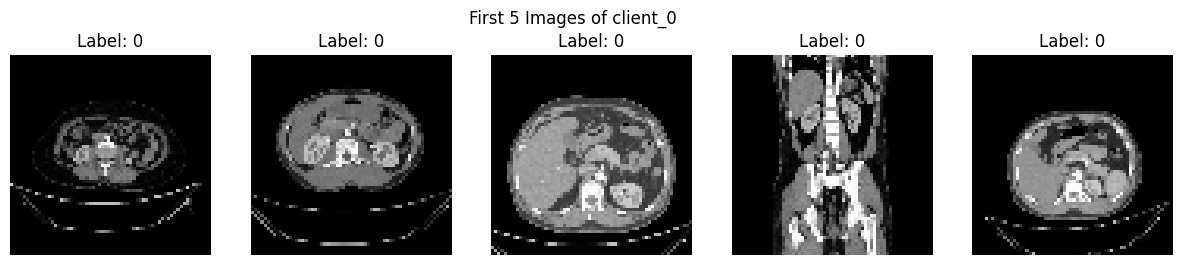

Client: client_1


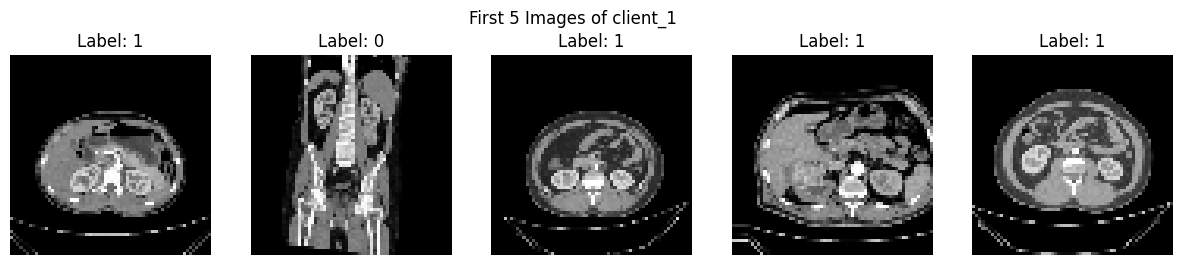

Client: client_2


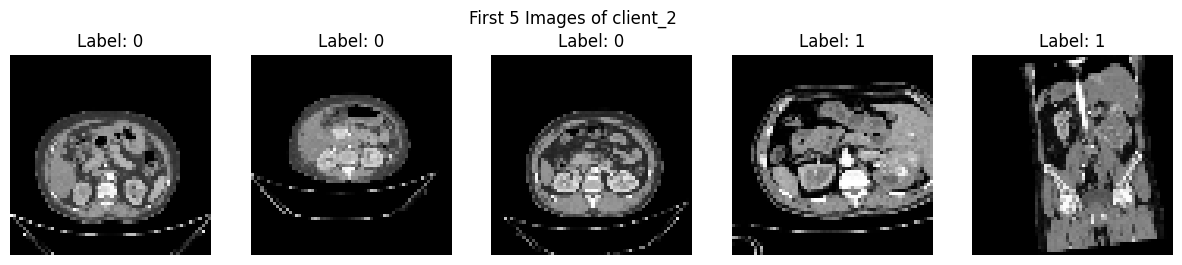

Client: client_3


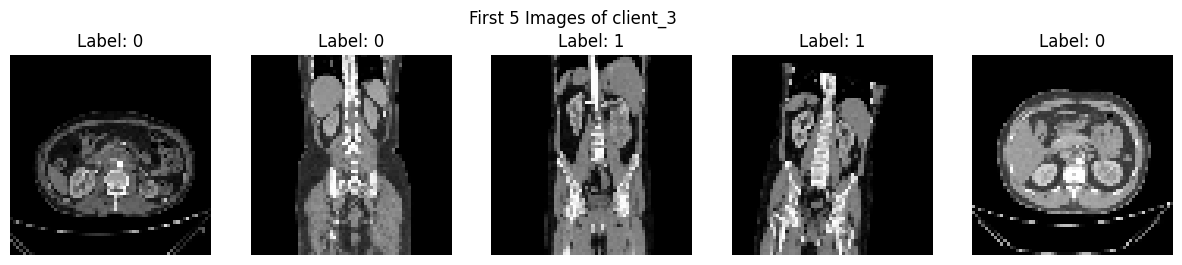

Client: client_4


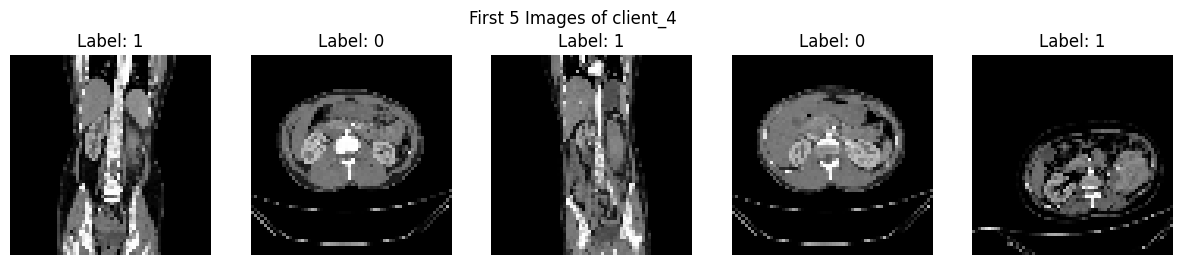

Client: client_5


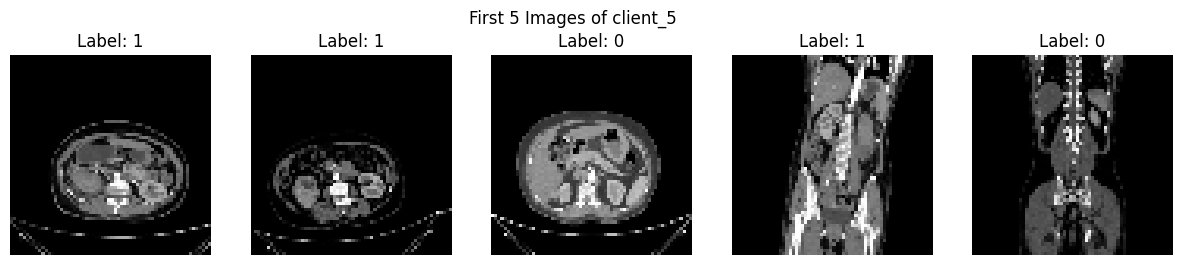

Client: client_6


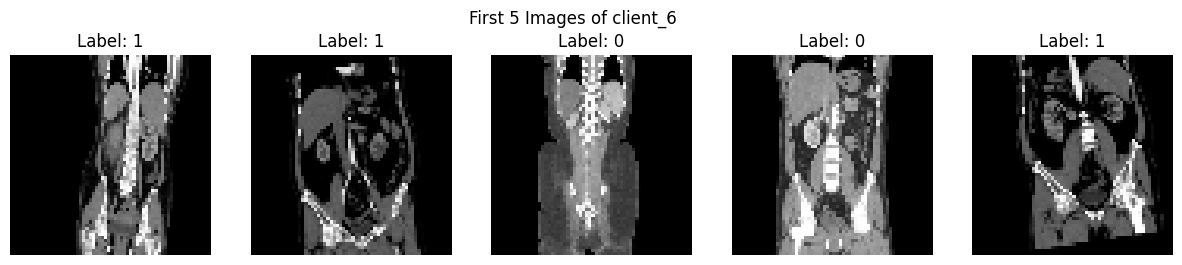

Client: client_7


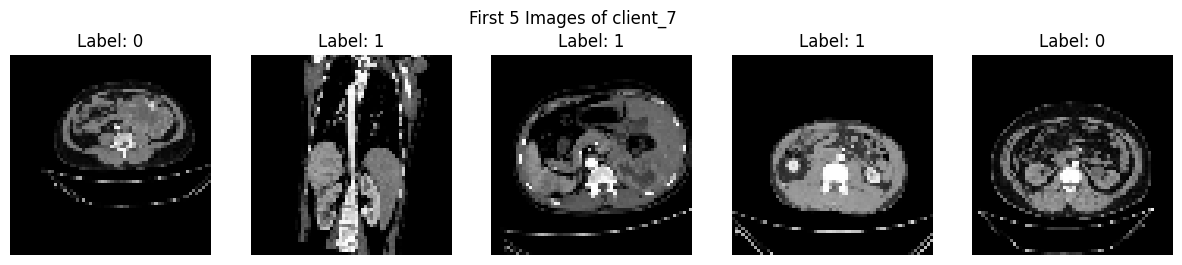

Client: client_8


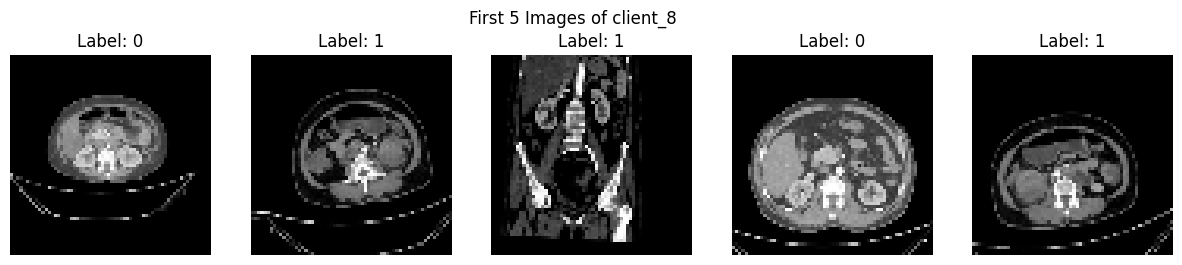

Client: client_9


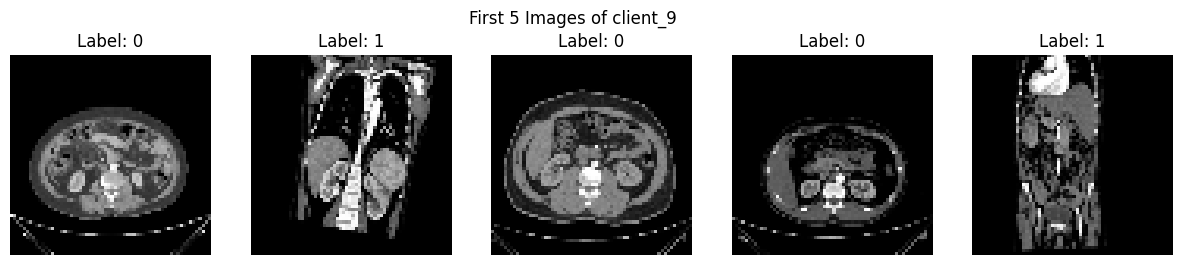

In [12]:
import matplotlib.pyplot as plt

def show_images_with_labels(images, labels, title=None):
    plt.figure(figsize=(15, 3))
    for i, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    if title:
        plt.suptitle(title)
    plt.show()

def print_first_5_images_with_labels(clients_datasets):
    for client_id, dataset in clients_datasets.items():
        print(f"Client: {client_id}")

        images_collected = []
        labels_collected = []
        for batch_images, batch_labels in dataset.take(1):
            images_slice = batch_images[:5]
            labels_slice = batch_labels[:5]
            batch_np_images = images_slice.numpy()
            batch_np_labels = labels_slice.numpy()
            for img, lbl in zip(batch_np_images, batch_np_labels):
                images_collected.append(img)
                labels_collected.append(lbl)

        show_images_with_labels(images_collected, labels_collected, title=f"First 5 Images of {client_id}")


print_first_5_images_with_labels(client_datasets)

In [13]:
for images, labels in client_datasets['client_0'].take(1):
    print(images.shape)
    print(labels.shape)
    print(labels)

(8, 64, 64, 3)
(8,)
tf.Tensor([1 1 1 0 0 0 0 1], shape=(8,), dtype=int32)


In [14]:
def create_keras_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')  # For 2-class classification
    ])
    return model


In [15]:
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=client_datasets['client_0'].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

In [16]:
keras_model = create_keras_model()
tff_model = tff.learning.models.functional_model_from_keras(
        keras_model,
        input_spec=client_datasets['client_0'].element_spec,
        loss_fn =tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics_constructor = collections.OrderedDict(
            accuracy = tf.keras.metrics.SparseCategoricalAccuracy
        )
    )

2026-02-17 09:19:29.730049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-17 09:19:29.731143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-17 09:19:29.731991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [17]:
sample_model = create_keras_model()

sample_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # for one-hot or multi-class
    metrics=['accuracy']
)

In [18]:
sample_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 128)        

In [19]:
with tf.device('/GPU:0'):
    sample_model.fit(client_datasets['client_0'], epochs=5, verbose=2)

Epoch 1/5


2026-02-17 09:20:12.232929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2026-02-17 09:20:12.419045: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7063d42b5d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-17 09:20:12.419061: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2026-02-17 09:20:12.421623: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-17 09:20:12.477997: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 - 2s - loss: 0.6393 - accuracy: 0.6418 - 2s/epoch - 36ms/step
Epoch 2/5
44/44 - 0s - loss: 0.4822 - accuracy: 0.7708 - 84ms/epoch - 2ms/step
Epoch 3/5
44/44 - 0s - loss: 0.3652 - accuracy: 0.8138 - 220ms/epoch - 5ms/step
Epoch 4/5
44/44 - 0s - loss: 0.1948 - accuracy: 0.9398 - 196ms/epoch - 4ms/step
Epoch 5/5
44/44 - 0s - loss: 0.1233 - accuracy: 0.9656 - 212ms/epoch - 5ms/step


In [21]:
@tff.tensorflow.computation
def server_init():
    return tff.learning.models.ModelWeights(*tff_model.initial_weights)

In [22]:
@tff.federated_computation
def initialize_fn():
  return tff.federated_eval(server_init, tff.SERVER)

In [23]:
tf_dataset_type = tff.SequenceType(
    tff.types.tensorflow_to_type(tff_model.input_spec)
)

In [24]:
model_weights_type = server_init.type_signature.result

In [25]:
@tf.function
#@tff.tensorflow.computation
def client_update(model, dataset, initial_weights, client_optimizer):
  """Performs training (using the server model weights) on the client's dataset."""
  # Initialize the client model with the current server weights and the optimizer
  # state.
  client_weights = initial_weights.trainable
  optimizer_state = client_optimizer.initialize(
      tf.nest.map_structure(tf.TensorSpec.from_tensor, client_weights)
  )

  # Use the client_optimizer to update the local model.
  for batch in dataset:
    x, y = batch
    with tf.GradientTape() as tape:
      tape.watch(client_weights)
      # Compute a forward pass on the batch of data
      outputs = model.predict_on_batch(
          model_weights=(client_weights, ()), x=x, training=True
      )
      loss = model.loss(output=outputs, label=y)

    # Compute the corresponding gradient
    grads = tape.gradient(loss, client_weights)

    # Apply the gradient using a client optimizer.
    optimizer_state, client_weights = client_optimizer.next(
        optimizer_state, weights=client_weights, gradients=grads
    )

    ##in_client_update_method.append(grads)

  weights = tff.learning.models.ModelWeights(client_weights, non_trainable=())
  return weights

In [26]:
@tff.tensorflow.computation(tf_dataset_type, model_weights_type)
def client_update_fn(tf_dataset, server_weights):
  client_optimizer = tff.learning.optimizers.build_sgdm(learning_rate=0.01)
  return client_update(tff_model, tf_dataset, server_weights, client_optimizer)

In [27]:
@tf.function
def server_update(model, mean_client_weights):
  """Updates the server model weights as the average of the client model weights."""
  del model  # Unused, just take the mean_client_weights.
  return mean_client_weights

In [28]:
@tff.tensorflow.computation(model_weights_type)
def server_update_fn(mean_client_weights):
  return server_update(tff_model, mean_client_weights)

In [29]:
federated_server_type = tff.FederatedType(model_weights_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)

In [30]:
@tff.federated_computation(federated_server_type, federated_dataset_type)
def next_fn(server_weights, federated_dataset):

    server_weights_at_client = tff.federated_broadcast(server_weights)

    client_weights  = tff.federated_map(
        client_update_fn, (federated_dataset, server_weights_at_client)
    )

    mean_client_weights = tff.federated_mean(client_weights)

    server_weights = tff.federated_map(server_update_fn, mean_client_weights)

    return server_weights, client_weights

In [31]:
federated_algorithm = tff.templates.IterativeProcess(
    initialize_fn=initialize_fn,
    next_fn=next_fn
)

In [32]:
str(federated_algorithm.initialize.type_signature)

'( -> <trainable=<float32[3,3,3,32],float32[32],float32[3,3,32,64],float32[64],float32[3,3,64,128],float32[128],float32[4608,128],float32[128],float32[128,2],float32[2]>,non_trainable=<>>@SERVER)'

In [33]:
client_datasets_list = [client_datasets[key] for key in sorted(client_datasets.keys())]
client_datasets_list = list(client_datasets.values())

In [34]:
server_weights = server_init()
captured_client_weights = []
server_weights_track = []

initial_weights = server_weights

for r in range(0, 4):
    server_weights, client_updates = next_fn(server_weights, client_datasets_list)
    captured_client_weights.append(client_updates)
    server_weights_track.append(server_weights)
    print("Finshed Round {}".format(r))

2026-02-17 09:23:17.919224: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-17 09:23:17.922543: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2026-02-17 09:23:17.922637: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2026-02-17 09:23:17.923181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-17 09:23:17.926980: I tensorflow/compiler/xla/stream_executor/

Finshed Round 0
Finshed Round 1
Finshed Round 2
Finshed Round 3


In [35]:
len(captured_client_weights[0])

10

In [36]:
len(captured_client_weights)

4

In [37]:
w = list(captured_client_weights[0][1].trainable)

In [38]:
client_weights = {}

In [39]:
for i in range(len(captured_client_weights)):
    client_weights["round" + str(i) + "weights"] = {}
    for j in range(len(captured_client_weights[i])):
        model_weights = list(captured_client_weights[i][j].trainable)
        model_to_flats = [tf.reshape(w, [-1]) for w in model_weights]
        flats_to_vector = tf.concat(model_to_flats, axis=0)
        client_weights["round" + str(i) + "weights"]["client_"+ str(j)] = flats_to_vector

In [40]:
client_weights

{'round0weights': {'client_0': <tf.Tensor: shape=(683458,), dtype=float32, numpy=
  array([-0.04540732, -0.12532887, -0.12956135, ..., -0.16877869,
         -0.00097198,  0.00097198], dtype=float32)>,
  'client_1': <tf.Tensor: shape=(683458,), dtype=float32, numpy=
  array([-0.04545673, -0.12448938, -0.12980916, ..., -0.1686997 ,
         -0.00067688,  0.00067688], dtype=float32)>,
  'client_2': <tf.Tensor: shape=(683458,), dtype=float32, numpy=
  array([-0.04511595, -0.12561128, -0.1300118 , ..., -0.1679105 ,
         -0.01088564,  0.01088564], dtype=float32)>,
  'client_3': <tf.Tensor: shape=(683458,), dtype=float32, numpy=
  array([-0.04495687, -0.12510623, -0.12934461, ..., -0.16939768,
         -0.00427617,  0.00427617], dtype=float32)>,
  'client_4': <tf.Tensor: shape=(683458,), dtype=float32, numpy=
  array([-0.04590455, -0.12556416, -0.12978396, ..., -0.16903394,
         -0.00722779,  0.00722779], dtype=float32)>,
  'client_5': <tf.Tensor: shape=(683458,), dtype=float32, numpy

In [41]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

def cluster_one_round_no_pca(client_weights_dict, n_clusters=2):
    """
    client_weights_dict: {"client_0": tf.Tensor shape (D,), ..., "client_9": tf.Tensor shape (D,)}
    returns: labels (len=10), X_feat (10 x D), client_keys (ordered)
    """
    # 1. Sort keys for consistent ordering
    client_keys = sorted(client_weights_dict.keys(), key=lambda s: int(s.split("_")[1]))

    # 2. Stack to (N_clients, D_features)
    X = np.stack([client_weights_dict[k].numpy() for k in client_keys], axis=0).astype(np.float32)

    # 3. Center/scale across clients (per-feature)
    X_mean = X.mean(axis=0, keepdims=True)
    X_std = X.std(axis=0, keepdims=True)
    X_std[X_std == 0] = 1.0
    X_norm = (X - X_mean) / X_std

    # 4. Normalize for cosine clustering
    # This projects the high-dimensional vectors onto a unit hypersphere
    X_cos = normalize(X_norm, norm="l2")

    # 5. Cluster
    # Note: Hierarchical clustering works fine on high dimensions,
    # but may be slower if the number of weights (D) is extremely large.
    clusterer = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric="cosine",
        linkage="average"
    )
    labels = clusterer.fit_predict(X_cos)

    return labels, X_cos, client_keys

In [42]:
round_cluster_results = {}

for r in range(4):
    round_name = f"round{r}weights"

    # Using the non-PCA function version
    # 'X_feat' is the (10, D) normalized weight matrix
    labels, X_feat, client_keys = cluster_one_round_no_pca(client_weights[round_name], n_clusters=2)

    # Maintain the same structure for your results dictionary
    round_cluster_results[round_name] = {
        "labels": labels,
        "client_keys": client_keys,
        "feat_shape": X_feat.shape
    }

    # Print output to match your previous style
    print(f"\n{round_name}  Feature shape={X_feat.shape}")
    for ck, lab in zip(client_keys, labels):
        print(f"  {ck} -> cluster {lab}")


round0weights  Feature shape=(10, 683458)
  client_0 -> cluster 0
  client_1 -> cluster 1
  client_2 -> cluster 0
  client_3 -> cluster 0
  client_4 -> cluster 0
  client_5 -> cluster 1
  client_6 -> cluster 0
  client_7 -> cluster 1
  client_8 -> cluster 0
  client_9 -> cluster 0

round1weights  Feature shape=(10, 683458)
  client_0 -> cluster 0
  client_1 -> cluster 1
  client_2 -> cluster 0
  client_3 -> cluster 0
  client_4 -> cluster 0
  client_5 -> cluster 1
  client_6 -> cluster 0
  client_7 -> cluster 1
  client_8 -> cluster 0
  client_9 -> cluster 0

round2weights  Feature shape=(10, 683458)
  client_0 -> cluster 0
  client_1 -> cluster 1
  client_2 -> cluster 0
  client_3 -> cluster 0
  client_4 -> cluster 0
  client_5 -> cluster 1
  client_6 -> cluster 0
  client_7 -> cluster 1
  client_8 -> cluster 0
  client_9 -> cluster 0

round3weights  Feature shape=(10, 683458)
  client_0 -> cluster 0
  client_1 -> cluster 1
  client_2 -> cluster 0
  client_3 -> cluster 0
  client_4 -

In [44]:
import numpy as np
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

def cluster_one_round_with_linkage_no_pca(client_weights_dict):
    """
    Performs hierarchical clustering directly on weights without PCA.
    Returns the linkage matrix for dendrogram plotting.
    """
    client_keys = sorted(client_weights_dict.keys(), key=lambda s: int(s.split("_")[1]))

    # 1. Stack to (n_clients, D)
    X = np.stack([client_weights_dict[k].numpy() for k in client_keys], axis=0).astype(np.float32)

    # 2. Center + scale (Standardization)
    X_mean = X.mean(axis=0, keepdims=True)
    X_std = X.std(axis=0, keepdims=True)
    X_std[X_std == 0] = 1.0
    X_norm = (X - X_mean) / X_std

    # 3. Normalize for cosine distance
    # (Important: cosine distance ignores magnitude, focusing on weight direction)
    X_cos = normalize(X_norm, norm="l2")

    # 4. Generate Linkage Matrix (The Hierarchical Tree)
    # This matrix contains the merge distances used for the dendrogram
    linkage_matrix = linkage(
        X_cos,
        method="average",
        metric="cosine"
    )

    return linkage_matrix, X_cos, client_keys

In [45]:
def plot_agglomerative_dendrogram(linkage_matrix, client_keys, round_name):
    plt.figure(figsize=(10, 5))
    dendrogram(
        linkage_matrix,
        labels=[ck.replace("client_", "C") for ck in client_keys],
        leaf_rotation=0,
        leaf_font_size=11,
        color_threshold=None
    )

    plt.title(
        f"{round_name}: Agglomerative Clustering Dendrogram\n"
        "(Average Linkage + Cosine Distance)",
        fontsize=14,
        weight="bold"
    )
    plt.xlabel("Clients")
    plt.ylabel("Cosine Distance")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


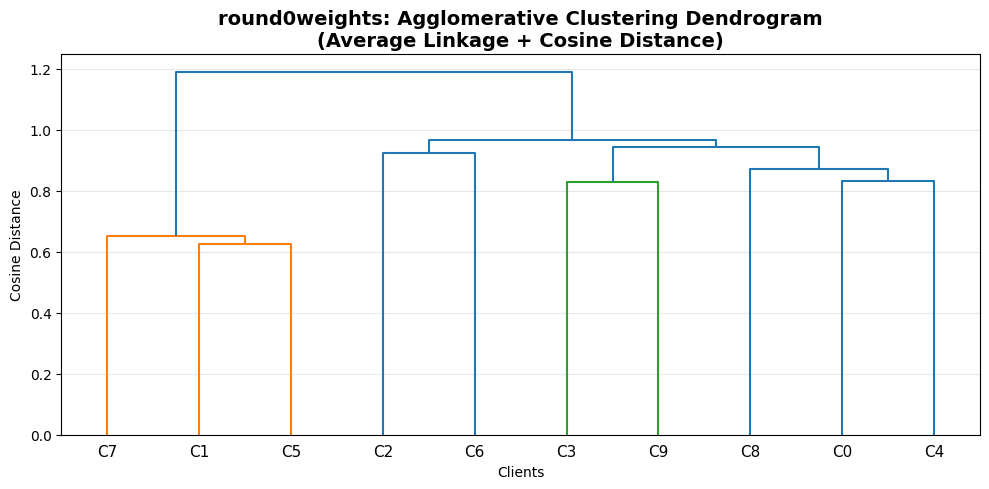

Verified: round0weights clustered using 683458 weight features.


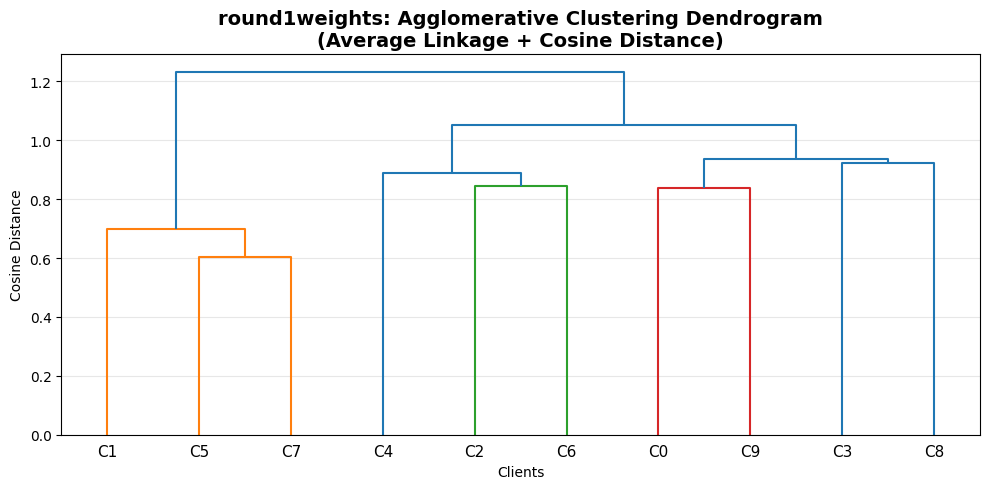

Verified: round1weights clustered using 683458 weight features.


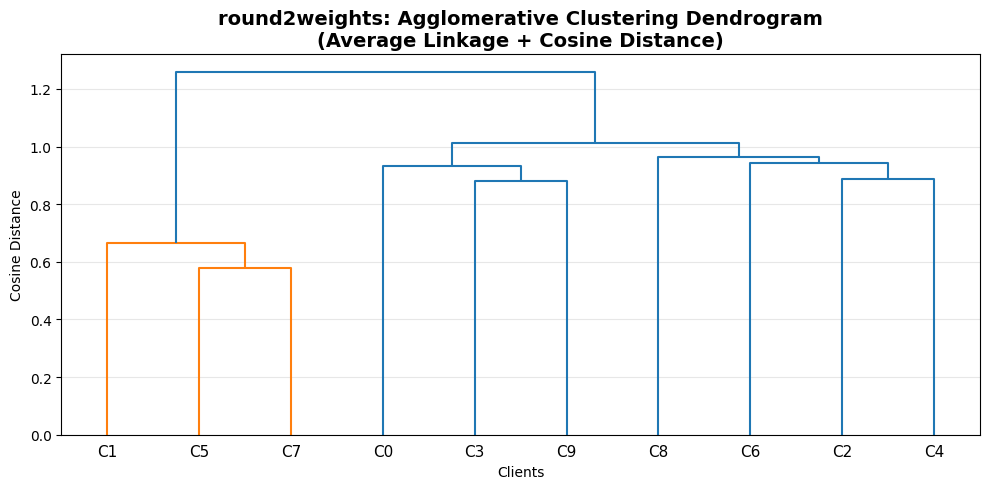

Verified: round2weights clustered using 683458 weight features.


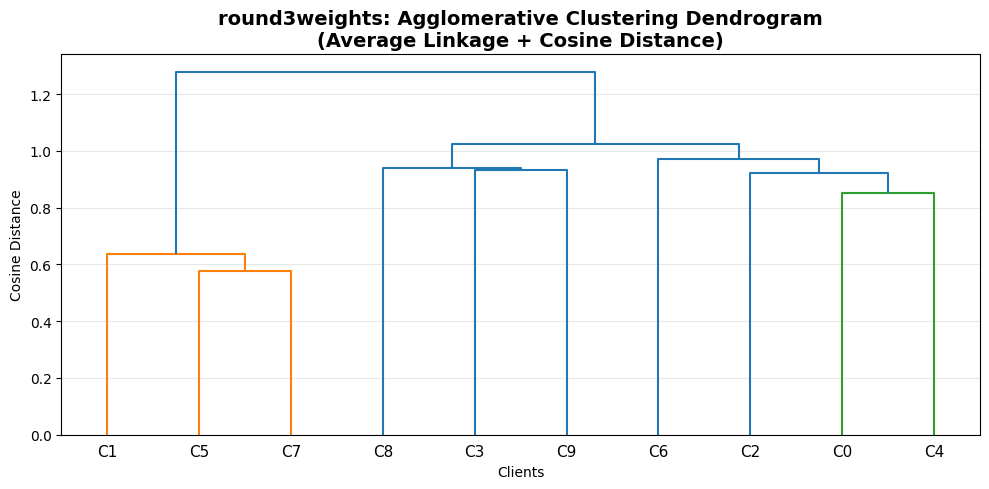

Verified: round3weights clustered using 683458 weight features.


In [46]:
for r in range(4):
    round_name = f"round{r}weights"
    linkage_mat, X_feat, client_keys = cluster_one_round_with_linkage_no_pca(client_weights[round_name])
    plot_agglomerative_dendrogram(linkage_mat, client_keys, round_name)
    print(f"Verified: {round_name} clustered using {X_feat.shape[1]} weight features.")

In [47]:
import numpy as np
from sklearn.preprocessing import normalize
import hdbscan

def hdbscan_one_round_no_pca(client_weights_dict, min_cluster_size=2, min_samples=1):
    """
    Performs HDBSCAN clustering on full client weights without PCA.
    Uses 'euclidean' on normalized vectors (which mimics cosine behavior).
    """
    client_keys = sorted(client_weights_dict.keys(), key=lambda s: int(s.split("_")[1]))

    # 1. Stack to (n_clients, D)
    X = np.stack([client_weights_dict[k].numpy() for k in client_keys], axis=0).astype(np.float32)

    # 2. Center/scale per-feature
    X_mean = X.mean(axis=0, keepdims=True)
    X_std = X.std(axis=0, keepdims=True)
    X_std[X_std == 0] = 1.0
    X_norm = (X - X_mean) / X_std

    # 3. Normalize for cosine-like distance
    # HDBSCAN's 'cosine' metric can be slow; using 'euclidean' on L2-normalized
    # data is mathematically equivalent for finding density-based clusters.
    X_cos = normalize(X_norm, norm="l2")

    # 4. HDBSCAN
    # Note: min_cluster_size is the most important hyperparameter here.
    clusterer = hdbscan.HDBSCAN(
        metric="euclidean",
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_method="eom"
    )

    labels = clusterer.fit_predict(X_cos)
    probs = clusterer.probabilities_

    return labels, probs, X_cos, client_keys, clusterer

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

def plot_hdbscan_round_no_pca(rk, labels, probs, X_feat, client_keys):
    """
    Visualizes high-dimensional HDBSCAN clusters by projecting them to 2D using t-SNE.
    """
    # 1. Project high-dim weights to 2D for visualization only
    # Perplexity is kept low because we only have 10 clients
    tsne = TSNE(n_components=2, perplexity=min(5, len(client_keys)-1), random_state=42)
    Z_vis = tsne.fit_transform(X_feat)

    x, y = Z_vis[:, 0], Z_vis[:, 1]
    xlab, ylab = "t-SNE 1", "t-SNE 2"

    plt.figure(figsize=(8, 6))
    plt.style.use("seaborn-v0_8-whitegrid")

    unique_labels = sorted(set(labels))
    for lab in unique_labels:
        idx = (labels == lab)
        if lab == -1:
            # Noise points
            plt.scatter(x[idx], y[idx], s=180, marker="x", color="gray",
                        linewidths=2, alpha=0.9, label="Noise (-1)")
        else:
            # Size reflects membership confidence from HDBSCAN
            sizes = 120 + 300 * probs[idx]
            plt.scatter(x[idx], y[idx], s=sizes, alpha=0.85,
                        edgecolor="black", linewidth=1.0, label=f"Cluster {lab}")

    # Annotate client IDs
    for i, ck in enumerate(client_keys):
        plt.text(x[i] + 0.1, y[i] + 0.1, ck.replace("client_", "C"),
                 fontsize=10, weight="bold")

    plt.title(f"{rk}: HDBSCAN on Full Weights (t-SNE Projection)\n"
              f"Features: {X_feat.shape[1]} params", fontsize=14, weight="bold")
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.legend(frameon=True, fancybox=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

calculating Distance Matrix between clients using millions of parameters. HDBSCAN (and the t-SNE in the plotting function) tries to keep these massive calculations in your RAM. If your CNN has 10 million weights, a single X_feat matrix for 10 clients is manageable, but the internal distance math can spike and trigger an "Out of Memory" (OOM) crash.

In [ ]:
round_hdbscan_results = {}

for r in range(4):
    rk = f"round{r}weights"
    labels, probs, X_feat, client_keys, clusterer = hdbscan_one_round_no_pca(
        client_weights[rk],
        min_cluster_size=2,
        min_samples=1
    )

    round_hdbscan_results[rk] = {
        "labels": labels,
        "probs": probs,
        "client_keys": client_keys,
        "X_feat": X_feat # Storing full features (careful with memory if D is huge)
    }

    print(f"\n{rk} | Total Features: {X_feat.shape[1]}")
    for ck, lab, pr in zip(client_keys, labels, probs):
        label_text = f"label {lab}" if lab != -1 else "NOISE"
        print(f"  {ck} -> {label_text}   prob={pr:.3f}")

    # 2. Use the plotting function that projects high-dim data to 2D
    plot_hdbscan_round_no_pca(rk, labels, probs, X_feat, client_keys)